In [13]:
from roofline_utils import *
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import chi2_contingency
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelEncoder

## Open the CSV file

In [14]:

resultsCSV = 'few-shot-inference-results.csv'

dtypes['language'] = 'string'
dtypes['numTokens'] = np.int64
dtypes['kernelCode'] = 'string'
dtypes['isBB'] = np.int64
dtypes['class'] = 'string'
dtypes['answer'] = 'string'
dtypes['topp'] = np.float64
dtypes['temp'] = np.float64
dtypes['llmResponse'] = 'string'
dtypes['trial'] = np.int64
dtypes['isTrain'] = np.int64

df = pd.read_csv(resultsCSV, quotechar='\"', dtype=dtypes)

In [15]:
print(df.shape)
print(df.columns)

df.drop(['kernelCode'], axis=1, inplace=True)

print(df.shape)
print(df.columns)

(340, 27)
Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language', 'numTokens',
       'kernelCode', 'isBB', 'class', 'answer', 'isTrain', 'trial', 'topp',
       'temp', 'llmResponse'],
      dtype='object')
(340, 26)
Index(['Kernel Name', 'traffic', 'dpAI', 'spAI', 'dpPerf', 'spPerf', 'xtime',
       'Block Size', 'Grid Size', 'device', 'intops', 'intPerf', 'intAI',
       'targetName', 'exeArgs', 'kernelName', 'language', 'numTokens', 'isBB',
       'class', 'answer', 'isTrain', 'trial', 'topp', 'temp', 'llmResponse'],
      dtype='object')


In [16]:
df['isLLMCorrect'] = df.apply(lambda x: x['answer'] == x['llmResponse'], axis=1)

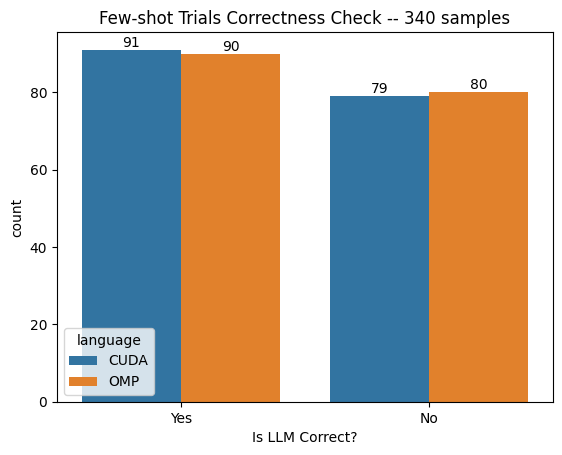

In [23]:
ax = sns.countplot(data=df, order=df['isLLMCorrect'].value_counts(ascending=False).index, hue='language', x='isLLMCorrect')

#abs_values = df['isLLMCorrect'].value_counts(ascending=False)
#rel_values = df['isLLMCorrect'].value_counts(ascending=False, normalize=True).values * 100
#lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

#ax.bar_label(container=ax.containers[0], labels=lbls)
for i in ax.containers:
    ax.bar_label(i,)

ax.set_xlabel('Is LLM Correct?')
ax.set_title(f'Few-shot Trials Correctness Check -- {df.shape[0]} samples')

ax.set_xticks([0, 1])
ax.set_xticklabels(['Yes', 'No'])

plt.show()

   temp  topp  isLLMCorrect  count    tempTopp
0   0.1   0.2         False    159  (0.1, 0.2)
1   0.1   0.2          True    181  (0.1, 0.2)


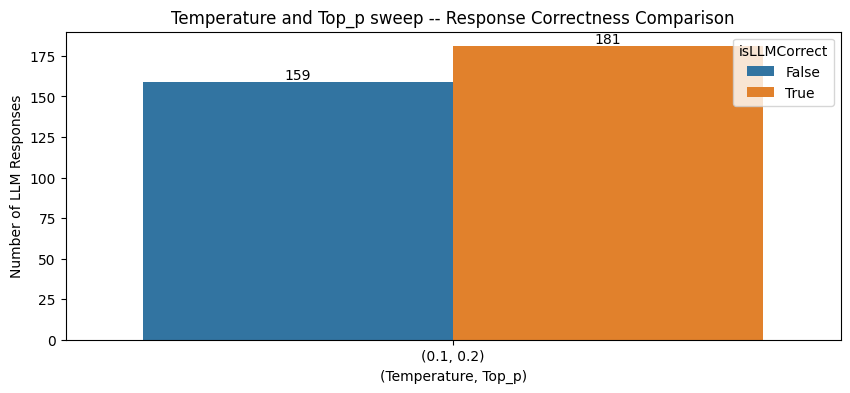

In [18]:
# visualize by levels
grouped = df.groupby(['temp', 'topp', 'isLLMCorrect'])['isLLMCorrect'].value_counts().reset_index()


grouped['tempTopp'] = list(zip(grouped['temp'], grouped['topp']))
grouped['tempTopp'] = grouped['tempTopp'].apply(str)

print(grouped)

fig, ax = plt.subplots(1,1, figsize=(10,4))
sns.barplot(data=grouped, x='tempTopp', y='count', hue='isLLMCorrect', ax = ax)

ax.set_xlabel('(Temperature, Top_p)')
ax.set_ylabel('Number of LLM Responses')
ax.set_title('Temperature and Top_p sweep -- Response Correctness Comparison')

for i in ax.containers:
    ax.bar_label(i,)

plt.show()



In [21]:
def make_confusion_plot(df, title):
    cf_matrix = confusion_matrix(df['answer'], df['llmResponse'], labels=['Compute', 'Bandwidth'])
    print(cf_matrix)

    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v2}\n{v3}" for v2, v3 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    #ax = sns.heatmap(cf_matrix, annot=True, fmt='g')
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='')

    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_title(title)

    ax.set_xticklabels(['Compute-Bound', 'Bandwidth-Bound'])
    ax.set_yticklabels(['Compute-Bound', 'Bandwidth-Bound'])

    plt.show()
    return

[[71 14]
 [66 19]]


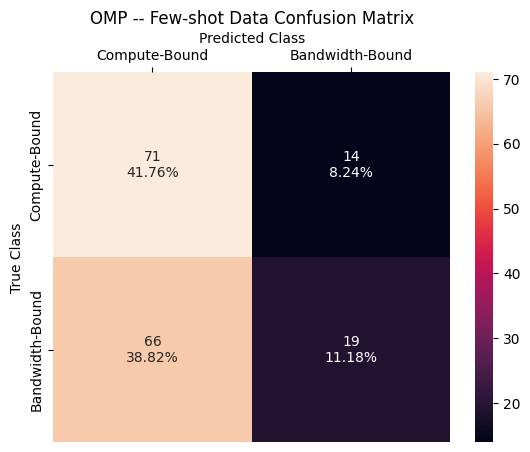

[[49 36]
 [43 42]]


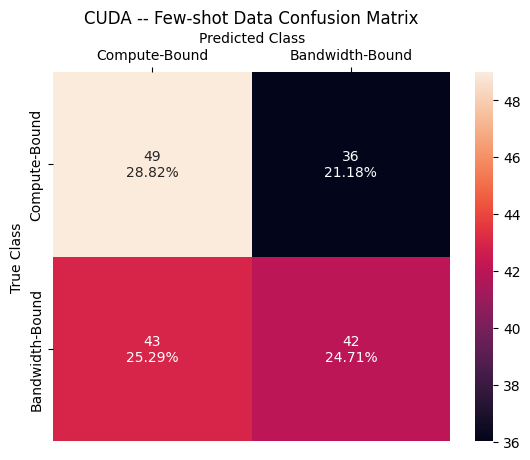

[[120  50]
 [109  61]]


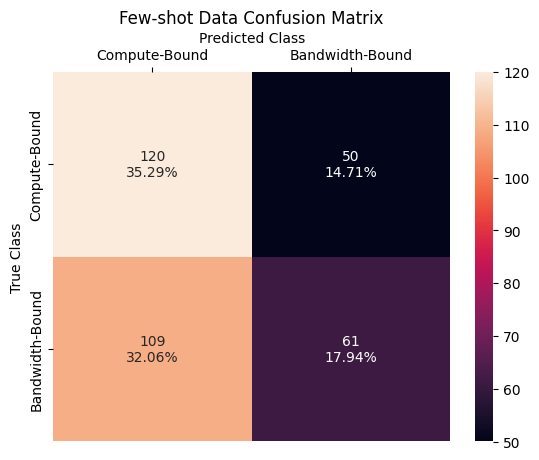

In [41]:

ompSubset = df[df['language'] == 'OMP']
make_confusion_plot(ompSubset, 'OMP -- Few-shot Data Confusion Matrix')

cudaSubset = df[df['language'] == 'CUDA']
make_confusion_plot(cudaSubset, 'CUDA -- Few-shot Data Confusion Matrix')

make_confusion_plot(df, 'Few-shot Data Confusion Matrix')

In [8]:

class_report = classification_report(df['answer'], df['llmResponse'], labels=['Compute', 'Bandwidth'], target_names=['Compute-Bound', 'Bandwidth-Bound'])
print(class_report)

# precision: Percentage of correct predictions relative to total predictions

                 precision    recall  f1-score   support

  Compute-Bound       0.52      0.71      0.60       170
Bandwidth-Bound       0.55      0.36      0.43       170

       accuracy                           0.53       340
      macro avg       0.54      0.53      0.52       340
   weighted avg       0.54      0.53      0.52       340



## Chi-Squared Test

We want to know: are the hyperparameters of the model statistically significant in affecting the outcomes of the predictions?

If no: we'll use small temperature and top_p in future LLM uses

If yes: we'll use the best of the sampled temperature and top_p values for future LLM inference

---------------

Null hypothesis (H₀): The two categorical hyperparameters have no effect on the binary predictions of the model.

Alternative hypothesis (H₁): The two categorical hyperparameters do have an effect on the binary predictions of the model.

In [9]:
# Let's start with a contingency table

# The desired columns are:
# Row 1 (temp, topp combo): [# samples LLM is wrong, # samples LLM is correct]
# Row 2 (temp, topp combo): [# samples LLM is wrong, # samples LLM is correct]
# Row 3 (temp, topp combo): [# samples LLM is wrong, # samples LLM is correct]
# etc.

# Row 1 (temp, topp combo): [# samples predicted CB, # samples predicted BB]
# Row 2 (temp, topp combo): [# samples predicted CB, # samples predicted BB]
# Row 3 (temp, topp combo): [# samples predicted CB, # samples predicted BB]
# etc.

grouped = df.groupby(['temp', 'topp', 'isLLMCorrect'])['isLLMCorrect'].value_counts().reset_index()
grouped['tempTopp'] = list(zip(grouped['temp'], grouped['topp']))
grouped['tempTopp'] = grouped['tempTopp'].apply(str)
grouped.drop(['temp', 'topp'], inplace=True, axis=1)
#print(grouped)
#print()

contTable = grouped.pivot(index='tempTopp', columns='isLLMCorrect', values='count').reset_index().reset_index(drop=True)
#contTable.drop(['isLLMCorrect'], inplace=True, axis=1)
contTable = contTable.rename_axis(None, axis=1)

contTable = contTable.rename(columns={False:'LLMisWRONG', True:'LLMisRIGHT'})
print(contTable)
print(contTable.columns)


contingency_table = contTable[['LLMisWRONG', 'LLMisRIGHT']].to_numpy()
print(contingency_table)

chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies: \n{expected}")

# Interpretation:
if p_value < 0.05:
    print("Reject the null hypothesis: The hyperparameters significantly affect the predictions.")
else:
    print("Fail to reject the null hypothesis: The hyperparameters do not significantly affect the predictions.")





     tempTopp  LLMisWRONG  LLMisRIGHT
0  (0.1, 0.2)         159         181
Index(['tempTopp', 'LLMisWRONG', 'LLMisRIGHT'], dtype='object')
[[159 181]]
Chi-Square Statistic: 0.0
P-value: 1.0
Degrees of Freedom: 0
Expected Frequencies: 
[[159. 181.]]
Fail to reject the null hypothesis: The hyperparameters do not significantly affect the predictions.


In [10]:
# Let's start with a contingency table

# The desired columns are:
# Row 1 (temp, topp combo): [# samples LLM is wrong, # samples LLM is correct]
# Row 2 (temp, topp combo): [# samples LLM is wrong, # samples LLM is correct]
# Row 3 (temp, topp combo): [# samples LLM is wrong, # samples LLM is correct]
# etc.

# Row 1 (temp, topp combo): [# samples predicted CB, # samples predicted BB]
# Row 2 (temp, topp combo): [# samples predicted CB, # samples predicted BB]
# Row 3 (temp, topp combo): [# samples predicted CB, # samples predicted BB]
# etc.

grouped = df.groupby(['temp', 'topp', 'llmResponse'])['llmResponse'].value_counts().reset_index()
grouped['tempTopp'] = list(zip(grouped['temp'], grouped['topp']))
grouped['tempTopp'] = grouped['tempTopp'].apply(str)
grouped.drop(['temp', 'topp'], inplace=True, axis=1)
#print(grouped)
#print()

contTable = grouped.pivot(index='tempTopp', columns='llmResponse', values='count').reset_index().reset_index(drop=True)
contTable = contTable.rename_axis(None, axis=1)

print(contTable)
print(contTable.columns)


contingency_table = contTable[['Bandwidth', 'Compute']].to_numpy()
print(contingency_table)

chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies: \n{expected}")

# Interpretation:
if p_value < 0.05:
    print("Reject the null hypothesis: The hyperparameters significantly affect the predictions.")
else:
    print("Fail to reject the null hypothesis: The hyperparameters do not significantly affect the predictions.")


# Should we do Bonferroni correction for this test?


     tempTopp  Bandwidth  Compute
0  (0.1, 0.2)        111      229
Index(['tempTopp', 'Bandwidth', 'Compute'], dtype='string')
[[111 229]]
Chi-Square Statistic: 0.0
P-value: 1.0
Degrees of Freedom: 0
Expected Frequencies: 
[[111. 229.]]
Fail to reject the null hypothesis: The hyperparameters do not significantly affect the predictions.


## Area Under Curve + ROC Curve

ROC AUC Score: 0.5323529411764706


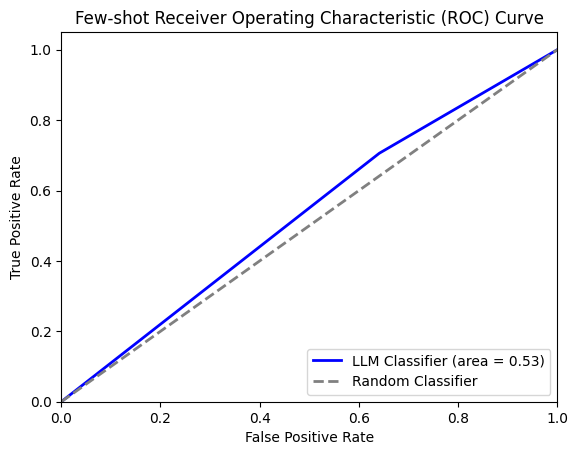

In [39]:
# Encode the categorical string labels to integers
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(df['answer'])
predicted_labels_encoded = label_encoder.transform(df['llmResponse'])

# Calculate ROC AUC score
roc_auc = roc_auc_score(true_labels_encoded, predicted_labels_encoded)
print(f"ROC AUC Score: {roc_auc}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(true_labels_encoded, predicted_labels_encoded)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'LLM Classifier (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Few-shot Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [37]:
def make_token_correct_count_plot(df, title):

    #fig, ax = plt.subplots(1,1, figsize=(5,12))
    grouped = df.groupby(['numTokens', 'isLLMCorrect', 'language'])['isLLMCorrect'].value_counts().reset_index()

    print(grouped.columns)
    print(grouped)
    grouped['(lang_isLLMCorrect)'] = list(zip(grouped['language'], grouped['isLLMCorrect']))
    grouped['(lang_isLLMCorrect)'] = grouped['(lang_isLLMCorrect)'].apply(str)
    #pivoted = grouped.pivot(index='numTokens', columns='(lang_isLLMCorrect)', values='count')
    pivoted = grouped.pivot(index='(lang_isLLMCorrect)', columns='numTokens', values='count')

    plt.figure(figsize=(15,5))
    #sns.heatmap(pivoted, linewidth=0.5, linecolor='red', cmap='crest', annot=True, ax=ax)
    ax = sns.heatmap(pivoted, linewidth=0.5, linecolor='red', cmap='crest', annot=True)

    ax.set_ylabel('(Language, Is LLM Correct?)')
    ax.set_xlabel('Number of Source Code Tokens')
    ax.set_title(title)
    return

Index(['numTokens', 'isLLMCorrect', 'language', 'count'], dtype='object')
     numTokens  isLLMCorrect language  count
0          304          True      OMP      1
1          355          True      OMP      1
2          563          True      OMP      1
3          692          True      OMP      1
4          764          True      OMP      1
..         ...           ...      ...    ...
161       6570         False      OMP      1
162       6570          True      OMP      1
163       6878         False      OMP      1
164       6911         False      OMP      1
165       7062          True      OMP      1

[166 rows x 4 columns]
Index(['numTokens', 'isLLMCorrect', 'language', 'count'], dtype='object')
     numTokens  isLLMCorrect language  count
0          718          True     CUDA      1
1          901         False     CUDA      1
2          996          True     CUDA      1
3         1024          True     CUDA      1
4         1026         False     CUDA      1
..         ...    

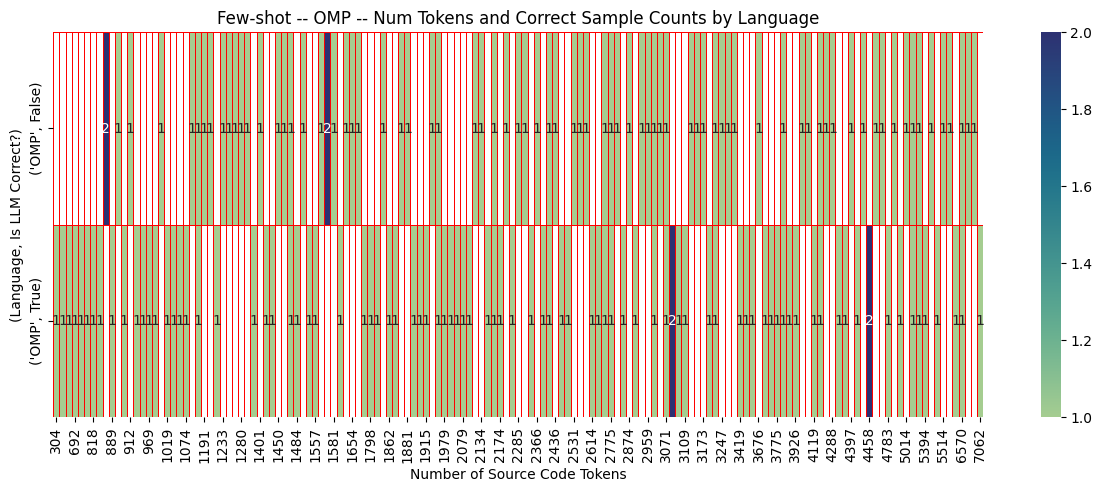

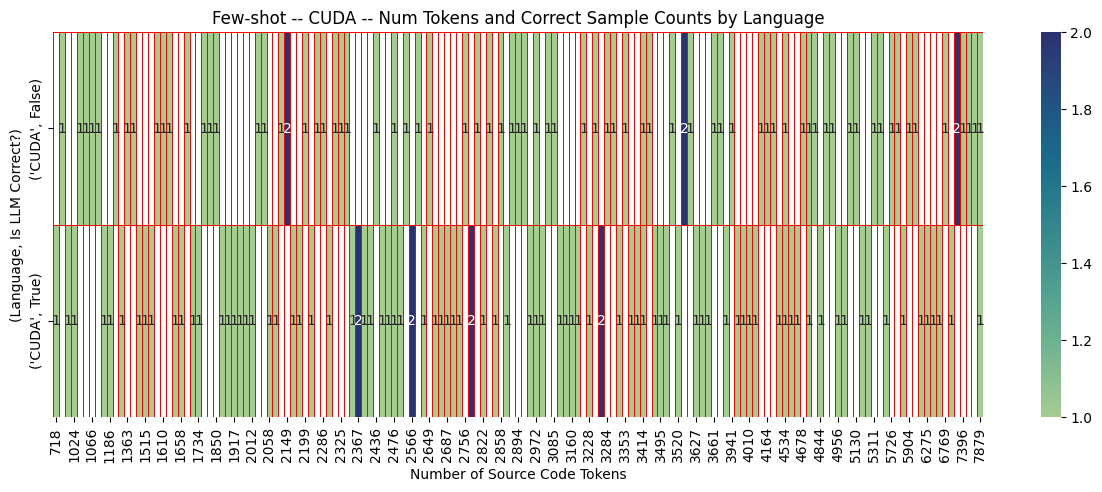

In [40]:
make_token_correct_count_plot(ompSubset, 'Few-shot -- OMP -- Num Tokens and Correct Sample Counts by Language')
make_token_correct_count_plot(cudaSubset, 'Few-shot -- CUDA -- Num Tokens and Correct Sample Counts by Language')